In [1]:
#coding=utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from tqdm import tqdm

from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

# from config_bdpt import input_size, root, proposalN, channels
from config import input_size, root, proposalN, channels
from utils.read_dataset_eval import read_dataset
from utils.auto_laod_resume import auto_load_resume
from utils.utils import TrainClock, save_args, AverageMeter, AUCMeter,calculate_accuracy
# from networks.model_bdpt import MainNet
from networks.model import MainNet

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

In [3]:
# dataset
set = 'Mura'
if set == 'CUB':
    root = './datasets/CUB_200_2011'  # dataset path
    # model path
    pth_path = "./models/cub_epoch144.pth"
    num_classes = 200
elif set == 'Aircraft':
    root = './datasets/FGVC-aircraft'  # dataset path
    # model path
    pth_path = "./models/air_epoch146.pth"
    num_classes = 100
elif set == 'Mura':
    root = r'E:\Xing\Data\MURA-v1.1'  # dataset path
    pth_path = r'C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth'
    num_classes = 1
elif set == 'Mura_bp':
#     model_path = './checkpoint/mura_bp_bimodel_adj0103'  # pth save path
    root = r'E:\Xing\Data\MURA-v1.1'  # dataset path
    pth_path = r'C:/Users/Xing/Projects/AirGo/MMAL-Net/checkpoint/mura_bp_bimodel_adj0103/best_model.pth'
    num_classes = 7

batch_size = 1

#load dataset
_, testloader = read_dataset(input_size, batch_size, root, set)
set

Loading Mura
Loading testset


'Mura'

In [4]:
# 定义模型
model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=channels)

model = model.to(DEVICE)

#加载checkpoint
if os.path.exists(pth_path):
    epoch = auto_load_resume(model, pth_path, status='test')
else:
    sys.exit('There is not a pth exist.')

Load model from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth
Resume from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth


In [5]:
criterion = nn.BCELoss()

In [7]:
# torch.cuda.set_device(3)
# from utils import calculate_accuracy

losses_val = AverageMeter('loss')
accuracies_val = AverageMeter('acc')
model.eval()
y = []
pred = []
study_out={}
study_label={}

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader)):
        
        if set == 'CUB':
            x, label, boxes, _ = data
        elif set == 'Mura_bp':
            x, label_bp, label,meta_data = data
        else:
            x, label,meta_data = data
            
        encounter = meta_data['encounter']
        image_val = x.to(DEVICE)
        targets_val = label.float().to(DEVICE)
        outputs_logits, local_imgs = model(image_val, epoch, i, 'test', DEVICE)[-2:]
        outputs_val = F.sigmoid(outputs_logits)
        
#         print(targets_val.shape,outputs_val.shape)
        
#         targets_val = data['label'].float().cuda()
#         images_val = data['image'].float().cuda()
#         outputs_val = model(images_val)
        loss_val = criterion(outputs_val, targets_val)
        
#         add_gl_image_index(images_val, patches_val, outputs_val, targets_val,  writer, subset='val', epoch=0, index = j)
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
        pred.append(outputs_val.cpu().numpy())
        
        for j in range(len(outputs_logits)):
            if study_out.get(encounter[j], -1) == -1:
                study_out[encounter[j]] = [outputs_val[j].item()]
                study_label[encounter[j]] = targets_val[j].item()
            else:
                study_out[encounter[j]] += [outputs_val[j].item()]

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)



0it [00:00, ?it/s]C:\Users\Windows\anaconda3\envs\env_torch\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\Windows\anaconda3\envs\env_torch\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)

1it [00:00,  1.07it/s]
3it [00:01,  1.49it/s]
6it [00:01,  2.06it/s]
9it [00:01,  2.82it/s]
11it [00:01,  3.77it/s]
14it [00:01,  4.96it/s]
16it [00:01,  6.30it/s]
18it [00:01,  7.72it/s]
20it [00:01,  9.23it/s]
22it [00:02, 10.90it/s]
24it [00:02, 12.38it/s]
26it [00:02, 13.93it/s]
29it [00:02, 15.55it/s]
32it [00:02, 16.48it/s]
35it [00:02, 17.84it/s]
37it [00:02, 18.18it/s]
40it [

768it [00:39, 19.77it/s]
771it [00:39, 20.00it/s]
774it [00:39, 20.25it/s]
777it [00:39, 20.08it/s]
780it [00:39, 19.69it/s]
783it [00:39, 20.49it/s]
786it [00:39, 20.43it/s]
789it [00:40, 20.49it/s]
792it [00:40, 19.91it/s]
795it [00:40, 20.45it/s]
798it [00:40, 20.57it/s]
801it [00:40, 20.36it/s]
804it [00:40, 20.27it/s]
807it [00:40, 20.19it/s]
810it [00:41, 20.73it/s]
813it [00:41, 20.10it/s]
816it [00:41, 20.66it/s]
819it [00:41, 20.27it/s]
822it [00:41, 20.21it/s]
825it [00:41, 20.66it/s]
828it [00:41, 20.97it/s]
831it [00:42, 20.71it/s]
834it [00:42, 20.07it/s]
837it [00:42, 20.18it/s]
840it [00:42, 19.74it/s]
843it [00:42, 19.97it/s]
846it [00:42, 20.17it/s]
849it [00:43, 20.05it/s]
852it [00:43, 19.87it/s]
855it [00:43, 20.78it/s]
858it [00:43, 21.01it/s]
861it [00:43, 20.36it/s]
864it [00:43, 20.07it/s]
867it [00:43, 20.27it/s]
870it [00:44, 20.78it/s]
873it [00:44, 20.49it/s]
876it [00:44, 20.34it/s]
879it [00:44, 20.41it/s]
882it [00:44, 20.09it/s]
885it [00:44, 20.52it/s]


1521it [01:16, 19.63it/s]
1524it [01:17, 20.01it/s]
1527it [01:17, 19.36it/s]
1530it [01:17, 20.10it/s]
1533it [01:17, 20.50it/s]
1536it [01:17, 20.37it/s]
1539it [01:17, 20.03it/s]
1542it [01:17, 19.31it/s]
1545it [01:18, 19.66it/s]
1548it [01:18, 19.98it/s]
1551it [01:18, 19.89it/s]
1553it [01:18, 19.44it/s]
1555it [01:18, 19.37it/s]
1557it [01:18, 19.51it/s]
1560it [01:18, 20.06it/s]
1563it [01:18, 20.19it/s]
1566it [01:19, 19.94it/s]
1568it [01:19, 19.64it/s]
1570it [01:19, 19.64it/s]
1572it [01:19, 19.66it/s]
1575it [01:19, 19.58it/s]
1578it [01:19, 20.22it/s]
1581it [01:19, 20.40it/s]
1584it [01:20, 20.18it/s]
1587it [01:20, 19.73it/s]
1589it [01:20, 19.64it/s]
1591it [01:20, 19.65it/s]
1593it [01:20, 19.62it/s]
1595it [01:20, 19.62it/s]
1597it [01:20, 19.58it/s]
1599it [01:20, 19.10it/s]
1602it [01:20, 19.66it/s]
1604it [01:21, 19.50it/s]
1607it [01:21, 19.57it/s]
1610it [01:21, 19.26it/s]
1613it [01:21, 19.63it/s]
1616it [01:21, 20.25it/s]
1619it [01:21, 20.17it/s]
1622it [01:2

2263it [01:54, 19.93it/s]
2265it [01:54, 19.77it/s]
2268it [01:54, 20.24it/s]
2271it [01:54, 19.74it/s]
2273it [01:54, 19.57it/s]
2275it [01:54, 19.34it/s]
2277it [01:54, 18.94it/s]
2279it [01:55, 18.75it/s]
2281it [01:55, 18.52it/s]
2283it [01:55, 18.76it/s]
2285it [01:55, 19.00it/s]
2288it [01:55, 19.68it/s]
2290it [01:55, 19.40it/s]
2292it [01:55, 18.87it/s]
2295it [01:55, 19.69it/s]
2297it [01:55, 19.57it/s]
2299it [01:56, 19.18it/s]
2302it [01:56, 20.01it/s]
2305it [01:56, 19.88it/s]
2308it [01:56, 20.23it/s]
2311it [01:56, 20.15it/s]
2314it [01:56, 20.61it/s]
2317it [01:56, 20.53it/s]
2320it [01:57, 19.39it/s]
2323it [01:57, 20.15it/s]
2326it [01:57, 20.37it/s]
2329it [01:57, 19.92it/s]
2332it [01:57, 20.03it/s]
2335it [01:57, 20.30it/s]
2338it [01:57, 20.42it/s]
2341it [01:58, 20.48it/s]
2344it [01:58, 20.23it/s]
2347it [01:58, 19.44it/s]
2350it [01:58, 19.73it/s]
2352it [01:58, 19.54it/s]
2354it [01:58, 19.56it/s]
2357it [01:58, 20.41it/s]
2360it [01:59, 19.82it/s]
2362it [01:5

3064it [02:33, 20.25it/s]
3067it [02:34, 20.47it/s]
3070it [02:34, 20.55it/s]
3073it [02:34, 19.35it/s]
3076it [02:34, 19.70it/s]
3078it [02:34, 19.49it/s]
3081it [02:34, 19.64it/s]
3084it [02:34, 19.63it/s]
3087it [02:35, 19.89it/s]
3089it [02:35, 19.80it/s]
3092it [02:35, 20.33it/s]
3095it [02:35, 20.73it/s]
3098it [02:35, 20.87it/s]
3101it [02:35, 20.65it/s]
3104it [02:35, 21.06it/s]
3107it [02:36, 20.32it/s]
3110it [02:36, 20.50it/s]
3113it [02:36, 19.27it/s]
3116it [02:36, 19.95it/s]
3119it [02:36, 20.30it/s]
3122it [02:36, 20.17it/s]
3125it [02:36, 20.03it/s]
3128it [02:37, 20.45it/s]
3131it [02:37, 20.35it/s]
3134it [02:37, 20.46it/s]
3137it [02:37, 19.92it/s]
3140it [02:37, 20.47it/s]
3143it [02:37, 20.42it/s]
3146it [02:37, 20.50it/s]
3149it [02:38, 20.38it/s]
3152it [02:38, 19.88it/s]
3155it [02:38, 20.55it/s]
3158it [02:38, 21.01it/s]
3161it [02:38, 21.09it/s]
3164it [02:38, 21.01it/s]
3167it [02:38, 20.87it/s]
3170it [02:39, 20.49it/s]
3173it [02:39, 20.65it/s]
3176it [02:3

val_loss:  0.42134619295592496 val_acc:  0.8301532703878525


In [8]:
import numpy as np

In [23]:
st_pred = []
st_y = []
index = []
for key in study_out.keys():
    index.append(key)
    st_pred.append(np.mean(study_out[key]))
    st_y.append(study_label[key])

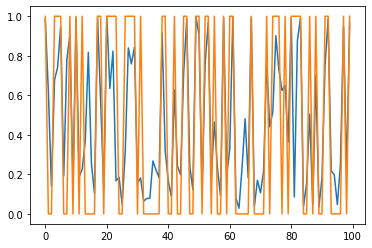

In [24]:
%matplotlib inline
plt.plot(st_pred[:100])
plt.plot(st_y[:100])

In [25]:
import numpy as np

In [26]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [27]:
y= np.asarray(st_y)
pred= np.asarray(st_pred).squeeze()

In [28]:
y,pred

(array([1., 0., 0., ..., 0., 0., 0.]),
 array([0.98444355, 0.61752983, 0.14043978, ..., 0.53914499, 0.01239034,
        0.10480023]))

In [29]:
y.shape

(1199,)

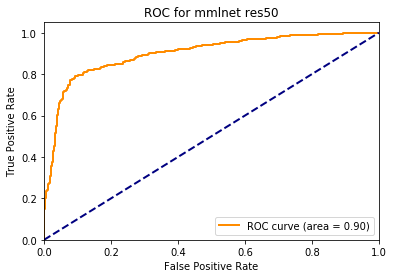

In [30]:
from sklearn import metrics

%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for mmlnet res50')
plt.legend(loc="lower right")
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)


In [32]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y,pred_t)

0.676062217050651

In [33]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.9288956127080181, 0.7360594795539034)

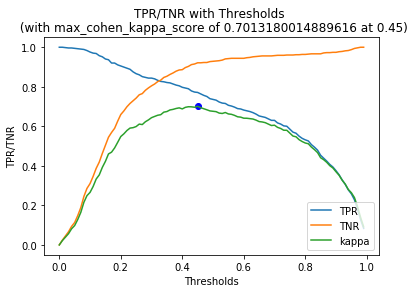

In [34]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='kappa')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [35]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

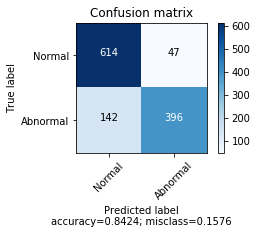

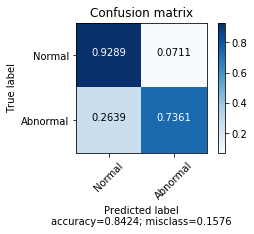

In [36]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0

In [43]:
a = torch.rand(3,3)

In [44]:
a

tensor([[0.2847, 0.4820, 0.1940],
        [0.7670, 0.0734, 0.9933],
        [0.7518, 0.1041, 0.5967]])

In [35]:
a.shape

torch.Size([3, 3])

In [36]:
b = [0,2,1]

In [37]:
b = torch.tensor(b)

In [55]:
bb = b.reshape(-1,1)

In [54]:
b

tensor([0, 2, 1])

In [39]:
l = F.nll_loss(a,b)

In [40]:
l

tensor(-0.5024)

In [46]:
sm = nn.LogSoftmax(dim=1)

In [47]:
aa = sm(a)

In [48]:
aa

tensor([[-1.1415, -0.9442, -1.2322],
        [-1.0130, -1.7066, -0.7866],
        [-0.8669, -1.5147, -1.0220]])

In [56]:
l = F.nll_loss(aa,bb)

RuntimeError: multi-target not supported at ..\aten\src\THNN/generic/ClassNLLCriterion.c:20

In [53]:
l

tensor(1.1476)

In [59]:
a = np.random.rand(3,4)

In [66]:
b = np.random.rand(2,4)

In [72]:
t = [a,b]

In [73]:
np.array(t).shape

(2,)

In [74]:
t.pop()

array([[0.255251, 0.802925, 0.39936 , 0.069087],
       [0.192725, 0.195726, 0.765414, 0.068067]])

In [75]:
t.pop()

array([[0.269292, 0.443954, 0.016551, 0.314709],
       [0.903049, 0.930926, 0.752409, 0.969705],
       [0.035113, 0.174226, 0.025869, 0.240254]])

In [76]:
t[0]

IndexError: list index out of range